In [1]:
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
import plotly.express as px
import pandas as pd
import os
from plotly.subplots import make_subplots

# Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from scipy import stats
from pathlib import Path
from sklearn.metrics import mean_absolute_error

## Load and extract data
Data is loaded using wget and extracted into the folders "images" and "masks"

In [5]:
if not os.path.exists("test_image.npy"):
  !wget -O test_image.npy "https://uni-muenster.sciebo.de/s/Ye3GpOyPj0rCeTh/download?path=%2F&files=private_test_image_reduced.npy"

--2023-07-05 09:30:21--  https://uni-muenster.sciebo.de/s/Ye3GpOyPj0rCeTh/download?path=%2F&files=private_test_image_reduced.npy
Resolving uni-muenster.sciebo.de (uni-muenster.sciebo.de)... 128.176.1.2
Connecting to uni-muenster.sciebo.de (uni-muenster.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335544448 (320M) [application/octet-stream]
Saving to: ‘test_image.npy’

test_image.npy      100%[===================>] 320.00M  49.3MB/s    in 5.2s    

2023-07-05 09:30:27 (61.7 MB/s) - ‘test_image.npy’ saved [335544448/335544448]



## Load previously trained model
This is not necessarily the last iteration of our training notebook but the one that produced best results

upload new model

In [3]:
# Load model architecture
json_file = open('model_optim.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [4]:
# Load model weights
model_loaded = keras.models.model_from_json(loaded_model_json)
model_loaded.load_weights("model_optim.h5")

## Load input image for prediction
Values are being normalized with zscore

In [6]:
input_test = stats.zscore(np.load("test_image.npy").transpose((1,2,0))) # Load and normalize values
X, Y, C = input_test.shape

In [7]:
input_test.shape

(4096, 4096, 10)

In [8]:
CROPPING_OFFSET = 5 # Define cropping offset previously used in training
padding_tuple = ((CROPPING_OFFSET,CROPPING_OFFSET), (CROPPING_OFFSET,CROPPING_OFFSET), (0,0))
input_pad = np.pad(input_test, padding_tuple) # Padding space is filled with zero values

In [9]:
input_pad.shape

(4106, 4106, 10)

In [10]:
pred = []

for y in range(CROPPING_OFFSET, Y + CROPPING_OFFSET): # Predict all X values per Y value to circumvent RAM restrictions
  y_crop = []
  for x in range(CROPPING_OFFSET, X + CROPPING_OFFSET):
    x_crop = input_pad[y-CROPPING_OFFSET : y+CROPPING_OFFSET+1, x-CROPPING_OFFSET: x+CROPPING_OFFSET+1,:]
    y_crop.append(x_crop)

  y_pred = model_loaded.predict(np.array(y_crop), verbose=2)
  pred.append(y_pred)
  del y_crop

128/128 - 8s - 8s/epoch - 62ms/step
128/128 - 0s - 178ms/epoch - 1ms/step
128/128 - 0s - 261ms/epoch - 2ms/step
128/128 - 0s - 259ms/epoch - 2ms/step
128/128 - 0s - 251ms/epoch - 2ms/step
128/128 - 0s - 186ms/epoch - 1ms/step
128/128 - 0s - 178ms/epoch - 1ms/step
128/128 - 0s - 175ms/epoch - 1ms/step
128/128 - 0s - 184ms/epoch - 1ms/step
128/128 - 0s - 171ms/epoch - 1ms/step
128/128 - 0s - 190ms/epoch - 1ms/step
128/128 - 0s - 184ms/epoch - 1ms/step
128/128 - 0s - 175ms/epoch - 1ms/step
128/128 - 0s - 179ms/epoch - 1ms/step
128/128 - 0s - 181ms/epoch - 1ms/step
128/128 - 0s - 184ms/epoch - 1ms/step
128/128 - 0s - 448ms/epoch - 3ms/step
128/128 - 0s - 188ms/epoch - 1ms/step
128/128 - 0s - 257ms/epoch - 2ms/step
128/128 - 0s - 174ms/epoch - 1ms/step
128/128 - 0s - 174ms/epoch - 1ms/step
128/128 - 0s - 180ms/epoch - 1ms/step
128/128 - 0s - 171ms/epoch - 1ms/step
128/128 - 0s - 181ms/epoch - 1ms/step
128/128 - 0s - 183ms/epoch - 1ms/step
128/128 - 0s - 176ms/epoch - 1ms/step
128/128 - 0s -

In [11]:
pred = np.array(pred)
pred.shape

(4096, 4096, 1)

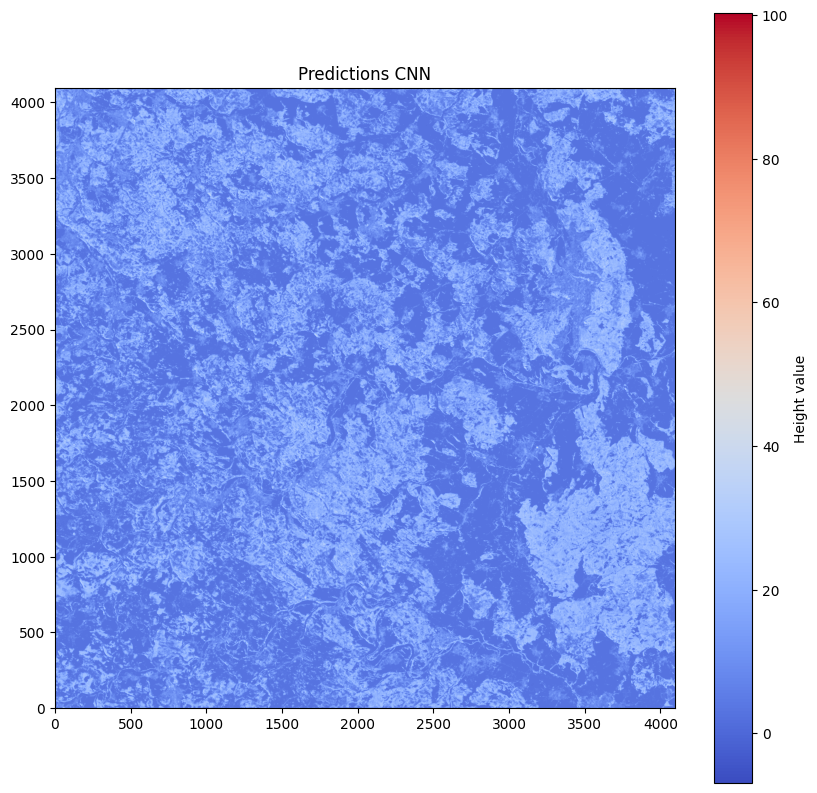

In [12]:
#pred = np.array(pred)
plt.figure(figsize=(10, 10))
plt.imshow(pred[:,:,0], origin="lower", cmap="coolwarm")
plt.title("Predictions CNN")
plt.colorbar(label='Height value')
plt.savefig("model02_prediction_private.png", bbox_inches="tight")
plt.show()
#pred.shape

In [13]:
pred_t = pred.transpose(2,0,1)
pred_t.shape

(1, 4096, 4096)

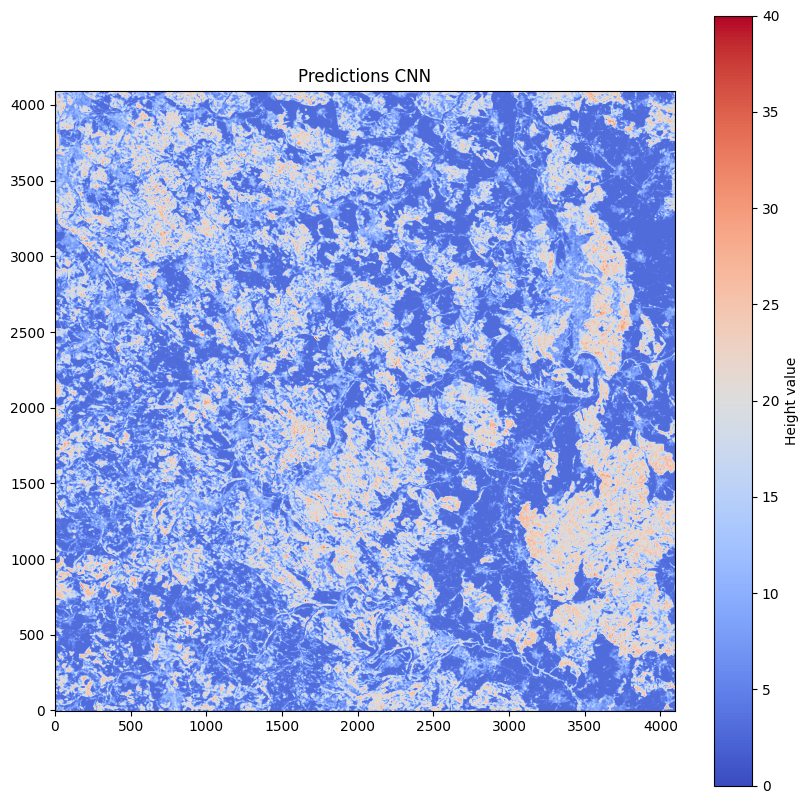

In [16]:
#pred = np.array(pred)
plt.figure(figsize=(10, 10))
plt.imshow(pred_t[0,:,:], origin="lower", cmap="coolwarm", vmin=0, vmax=40)
plt.title("Predictions CNN")
plt.colorbar(label='Height value')
plt.savefig("model02_prediction_private.png", bbox_inches="tight")
plt.show()
#pred.shape

In [15]:
with open("CNN_m2_private_prediction.npy", "wb") as f:
  np.save(f, pred_t)